In [1]:
# Link to the original noteboook: https://www.kaggle.com/dahouda/plant-pathology-2020

import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn import metrics
from sklearn.model_selection import train_test_split

from efficientnet.tfkeras import EfficientNetB7

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

from orchard.config import OrchardConfig

In [2]:
## this block is required to avoid issues with cudnn
from keras.backend.tensorflow_backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = False
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Using TensorFlow backend.


In [3]:
AUTO = tf.data.experimental.AUTOTUNE
strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

TRAINING = False

EPOCHS = 1 #50
BATCH_SIZE = 4 * strategy.num_replicas_in_sync #8 * strategy.num_replicas_in_sync

REPLICAS:  1


In [4]:
def format_path(st):
    return os.path.join(OrchardConfig.PATHOLOGY_DATASET_PATH, 'images', st + '.jpg')

In [5]:
train = pd.read_csv(os.path.join(OrchardConfig.PATHOLOGY_DATASET_PATH, 'train.csv'))
test = pd.read_csv(os.path.join(OrchardConfig.PATHOLOGY_DATASET_PATH, 'test.csv'))
sub = pd.read_csv(os.path.join(OrchardConfig.PATHOLOGY_DATASET_PATH, 'sample_submission.csv'))

train_paths = train.image_id.apply(format_path).values
test_paths = test.image_id.apply(format_path).values

train_labels = train.loc[:, 'healthy':].values


train_paths, valid_paths, train_labels, valid_labels = train_test_split(
     train_paths, train_labels, test_size=0.06, random_state=2020)


train_paths = train.image_id.apply(format_path).values
train_labels = train.loc[:, 'healthy':].values

(1365, 2048, 3)


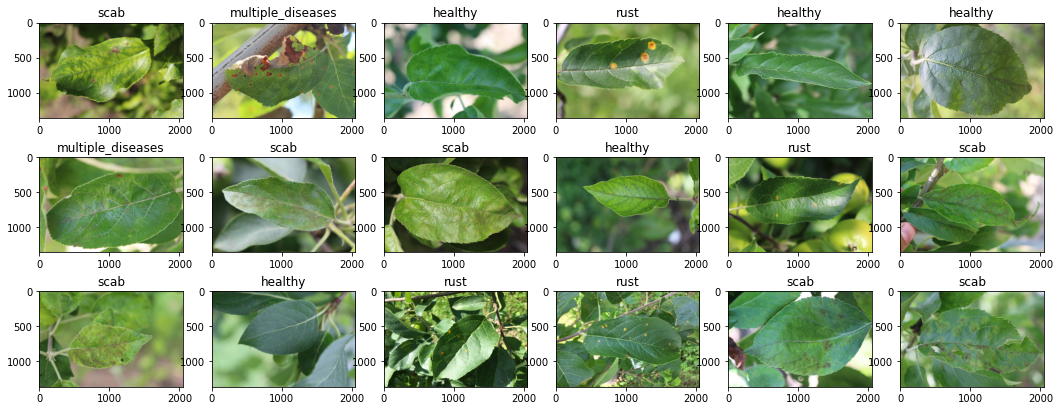

In [6]:
f, ax = plt.subplots(3, 6, figsize=(18, 7))
ax = ax.flatten()

for i in range(18):
    img = plt.imread(os.path.join(OrchardConfig.PATHOLOGY_DATASET_PATH, 'images', f'Train_{i}.jpg'))
    ax[i].set_title(train[train['image_id']==f'Train_{i}'].melt()[train[train['image_id']==f'Train_{i}'].melt().value == 1]['variable'].values[0])
    ax[i].imshow(img)
print(img.shape)

In [7]:
img_size = 192 #768

def decode_image(filename, label=None, image_size=(img_size, img_size)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None, seed=2020):
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
    
    if label is None:
        return image
    else:
        return image, label

In [8]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
     tf.data.Dataset
     .from_tensor_slices((valid_paths, valid_labels))
     .map(decode_image, num_parallel_calls=AUTO)
     .batch(BATCH_SIZE)
     .cache()
     .prefetch(AUTO)
 )

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_paths)
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
)

Learning rate schedule: 1e-05 to 1e-05 to 1e-05


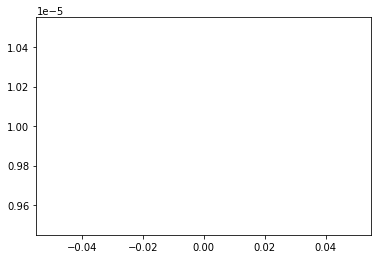

In [9]:
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)


rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [10]:
if TRAINING:
    # Here you can replace the EfficientNetB7 architecture with any other of the loaded ones and observe the result
    # VGG16, VGG19, InceptionV3, InceptionResNetV2, DenseNet121, DenseNet169, DenseNet201, Xception,
    # ResNet50, ResNet50V2, ResNet101V2, ResNet152V2, NASNetLarge, EfficientNetL2

    def get_model(use_model):
        base_model =  use_model(weights='noisy-student',
                                     include_top=False, pooling='avg',
                                     input_shape=(img_size, img_size, 3))
        x = base_model.output
        predictions = Dense(train_labels.shape[1], activation="softmax")(x)
        return Model(inputs=base_model.input, outputs=predictions)

    with strategy.scope():
        model = get_model(EfficientNetB7)

    model.compile(optimizer='nadam', loss='categorical_crossentropy',metrics=['categorical_accuracy'])
    #model.summary()

In [11]:
if TRAINING:
    history = model.fit(
                train_dataset, 
                steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
                callbacks=[lr_callback, ModelCheckpoint(filepath=OrchardConfig.PATHOLOGY_WEIGHTS_PATH, monitor='val_loss', save_best_only=True)],
                validation_data=valid_dataset, epochs=EPOCHS)

In [12]:
if TRAINING:
    #plt.plot(history.history['sparse_categorical_accuracy'], 
    plt.plot(history.history['categorical_accuracy'], label='Accuracy on the training set')
    plt.plot(history.history['val_categorical_accuracy'], label='Accuracy on the test set')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

In [13]:
if TRAINING:
    plt.plot(history.history['loss'], label='losses on the training set')
    plt.plot(history.history['val_loss'], label='losses on the test set')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [14]:
#model.save(name_model)

model = tf.keras.models.load_model(OrchardConfig.PATHOLOGY_WEIGHTS_PATH)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
`normal` is a deprecated alias for `truncated_normal`
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
probs = model.predict(test_dataset, verbose=1)
sub.loc[:, 'healthy':] = probs
sub.to_csv('submission.csv', index=False)
sub.head()

456/456 [==============================] - 31s 69ms/step


,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.235706,0.190663,0.369661,0.203970
1,Test_1,0.286879,0.223330,0.210304,0.279486
2,Test_2,0.273444,0.239737,0.196705,0.290114
3,Test_3,0.273500,0.237355,0.181030,0.308116
4,Test_4,0.269610,0.157529,0.317586,0.255274
